In [66]:
import numpy as np
from scipy.stats import mode
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [67]:
X = np.genfromtxt("data/data.csv", delimiter=',')
y = np.genfromtxt("data/label.csv", delimiter=',')

In [68]:
np.random.seed(42)

In [69]:
def euclidean_distance(x1, x2):
    euclidean_distance = np.sqrt(np.sum((x1 - x2) ** 2))
    return euclidean_distance

def cosine_distance(x1, x2):
    dot_product = np.dot(x1, x2)
    norm_x1 = np.linalg.norm(x1)
    norm_x2 = np.linalg.norm(x2)
    cosine_similarity = dot_product / (norm_x1 * norm_x2)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

def jarcard_distance(x1, x2):
    jarcard_similarity = np.sum(np.minimum(x1, x2)) / np.sum(np.maximum(x1, x2))
    jarcard_distance = 1 - jarcard_similarity
    return jarcard_distance

In [70]:
def assign_majority_labels(labels, y, k):
    majority_labels = np.zeros(10000)
    for cluster in range(k):
        cluster_indices = np.where(labels == cluster)
        cluster_actual_labels = y[cluster_indices]
        majority_label = mode(cluster_actual_labels)[0][0]
        majority_labels[cluster_indices] = majority_label
    return majority_labels

def calculate_accuracy(labels, y, k=10):
    pred_labels = assign_majority_labels(labels, y, 10)
    accuracy = np.sum(pred_labels == y) / len(y)
    return accuracy 

def calculate_sse(X, labels, centroids):
    sse = np.sum(np.sum((X[labels == i] - centroids[i])**2) for i in range(len(centroids)))
    return sse

In [71]:
def k_means_plusplus_centroids_init(X, distance_function=euclidean_distance, k=10):
    centroids = []
    centroids.append(X[np.random.choice(len(X))])
    for _ in range(1, k):
        distances = np.array([min(distance_function(x, c)**2 for c in centroids) for x in X])
        probabilities = distances / np.sum(distances)
        new_centroid_index = np.random.choice(len(X), p=probabilities)
        centroids.append(X[new_centroid_index])
    return np.array(centroids)

def k_means_centroids_init(X, k=10):
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    return centroids

def k_means(X, centroids, distance_function=euclidean_distance, stop_criteria="max_iters_complete", k=10, max_iters=200):
    labels = None
    itr = 0
    prev_sse, cur_sse = float('inf'), float('inf')
    while itr < max_iters:
        labels = np.argmin(np.array([[distance_function(x, c) for c in centroids] for x in X]), axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] for i in range(k)])
        prev_sse = cur_sse
        cur_sse = calculate_sse(X, labels, new_centroids)
        itr += 1
        if stop_criteria == "check_centroids":
            if np.array_equal(centroids, new_centroids):
                break
        elif stop_criteria == "sse_increase":
            if prev_sse < cur_sse:
                break
        centroids = new_centroids
    return labels, centroids, itr

In [72]:
# Question 1, 2, 3, 4

distance_function_list = [euclidean_distance, cosine_distance, jarcard_distance]
stop_criteria_list = ["check_centroids", "sse_increase", "max_iters_complete"]
results = {}

for distance_function in distance_function_list:
    init_centroids = k_means_plusplus_centroids_init(X, distance_function)
    for stop_criteria in stop_criteria_list:
        distance_function_name = str(distance_function).split()[1]
        start_time = time.time()
        labels, centroids, itr = k_means(X, init_centroids, distance_function, stop_criteria)
        end_time = time.time()
        sse = calculate_sse(X, labels, centroids)
        accuracy = calculate_accuracy(labels, y) * 100
        elapsed_time = end_time - start_time

        if distance_function_name not in results:
            results[distance_function_name] = {}
        results[distance_function_name][stop_criteria] = {"sse": sse, "accuracy": accuracy, "iterations": itr, "elapsed_time": elapsed_time}

In [73]:
for distance_function in results.keys():
    for stop_criteria in results[distance_function].keys():
        sse= results[distance_function][stop_criteria]["sse"]
        accuracy= results[distance_function][stop_criteria]["accuracy"]
        iterations = results[distance_function][stop_criteria]["iterations"]
        elapsed_time = results[distance_function][stop_criteria]["elapsed_time"]
        print(distance_function, stop_criteria)
        print(f"SSE: {sse}, Accuracy: {accuracy}, Iterations: {iterations}, Elapsed Time: {elapsed_time}")

euclidean_distance check_centroids
SSE: 25433212639.23864, Accuracy: 60.440000000000005, Iterations: 81, Elapsed Time: 71.5138738155365
euclidean_distance sse_increase
SSE: 25433212639.23864, Accuracy: 60.440000000000005, Iterations: 200, Elapsed Time: 175.38812112808228
euclidean_distance max_iters_complete
SSE: 25433212639.23864, Accuracy: 60.440000000000005, Iterations: 200, Elapsed Time: 174.4093599319458
cosine_distance check_centroids
SSE: 25419566793.996544, Accuracy: 61.33, Iterations: 71, Elapsed Time: 68.61487483978271
cosine_distance sse_increase
SSE: 25440247462.490417, Accuracy: 61.160000000000004, Iterations: 16, Elapsed Time: 15.685653924942017
cosine_distance max_iters_complete
SSE: 25419566793.996544, Accuracy: 61.33, Iterations: 200, Elapsed Time: 193.1032280921936
jarcard_distance check_centroids
SSE: 25417331725.239452, Accuracy: 60.33, Iterations: 80, Elapsed Time: 95.90016508102417
jarcard_distance sse_increase
SSE: 25487498983.53029, Accuracy: 60.89, Iterations: 

In [78]:
# Q1 Output

for distance_function in results.keys():
    for stop_criteria in ["check_centroids"]:
        sse= results[distance_function][stop_criteria]["sse"]
        print(f"{distance_function} -> SSE: {sse:.2f}")

euclidean_distance -> SSE: 25433212639.24
cosine_distance -> SSE: 25419566794.00
jarcard_distance -> SSE: 25417331725.24


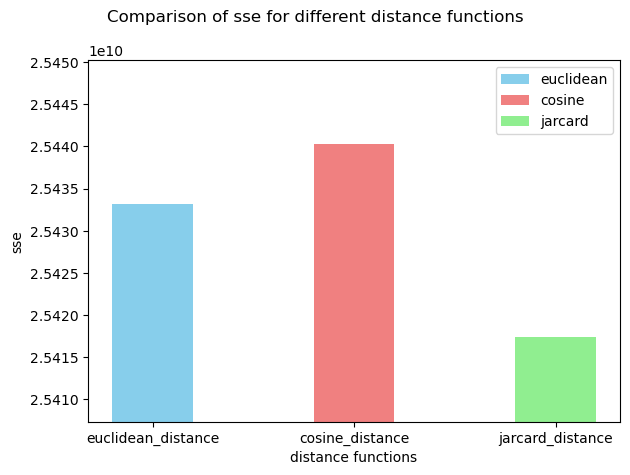

In [92]:
# Q1 Plot

plt.bar(0, results["euclidean_distance"]["check_centroids"]['sse'], width=0.4, color='skyblue', label='euclidean')
plt.bar(1, results["cosine_distance"]["sse_increase"]['sse'], width=0.4, color='lightcoral', label='cosine')
plt.bar(2, results["jarcard_distance"]["max_iters_complete"]['sse'], width=0.4, color='lightgreen', label='jarcard')
plt.suptitle('Comparison of sse for different distance functions')
plt.xlabel('distance functions')
plt.ylabel('sse')
plt.xticks(np.arange(len(list(results.keys()))), list(results.keys()))
plt.legend()
plt.ylim(min(results["euclidean_distance"]["check_centroids"]['sse'], results["cosine_distance"]["sse_increase"]['sse'], results["jarcard_distance"]["max_iters_complete"]['sse']) - 10000000, \
    max(results["euclidean_distance"]["check_centroids"]['sse'], results["cosine_distance"]["sse_increase"]['sse'], results["jarcard_distance"]["max_iters_complete"]['sse']) + 10000000)

plt.tight_layout()
plt.show()

In [94]:
# Q2 Output

for distance_function in results.keys():
    for stop_criteria in ["check_centroids"]:
        accuracy= results[distance_function][stop_criteria]["accuracy"]
        print(f"{distance_function} -> accuracy: {accuracy:.2f}")

euclidean_distance -> accuracy: 60.44
cosine_distance -> accuracy: 61.33
jarcard_distance -> accuracy: 60.33


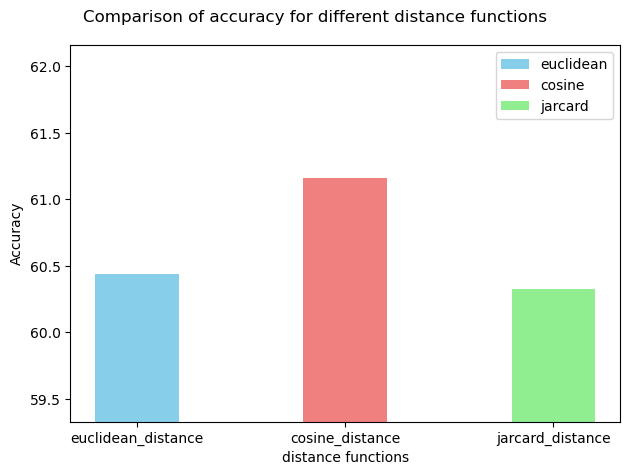

In [96]:
# Q2 Plot

plt.bar(0, results["euclidean_distance"]["check_centroids"]['accuracy'], width=0.4, color='skyblue', label='euclidean')
plt.bar(1, results["cosine_distance"]["sse_increase"]['accuracy'], width=0.4, color='lightcoral', label='cosine')
plt.bar(2, results["jarcard_distance"]["max_iters_complete"]['accuracy'], width=0.4, color='lightgreen', label='jarcard')
plt.suptitle('Comparison of accuracy for different distance functions')
plt.xlabel('distance functions')
plt.ylabel('Accuracy')
plt.xticks(np.arange(len(list(results.keys()))), list(results.keys()))
plt.legend()
plt.ylim(min(results["euclidean_distance"]["check_centroids"]['accuracy'], results["cosine_distance"]["sse_increase"]['accuracy'], results["jarcard_distance"]["max_iters_complete"]['accuracy']) - 1, \
    max(results["euclidean_distance"]["check_centroids"]['accuracy'], results["cosine_distance"]["sse_increase"]['accuracy'], results["jarcard_distance"]["max_iters_complete"]['accuracy']) + 1)

plt.tight_layout()
plt.show()

In [102]:
# Q3 Output

for distance_function in results.keys():
    print(distance_function)
    for stop_criteria in results[distance_function].keys():
        iterations = results[distance_function][stop_criteria]["iterations"]
        elapsed_time = results[distance_function][stop_criteria]["elapsed_time"]
        print(f"{stop_criteria} -> Iterations: {iterations}, Elapsed Time: {elapsed_time:.2f}")

euclidean_distance
check_centroids -> Iterations: 81, Elapsed Time: 71.51
sse_increase -> Iterations: 200, Elapsed Time: 175.39
max_iters_complete -> Iterations: 200, Elapsed Time: 174.41
cosine_distance
check_centroids -> Iterations: 71, Elapsed Time: 68.61
sse_increase -> Iterations: 16, Elapsed Time: 15.69
max_iters_complete -> Iterations: 200, Elapsed Time: 193.10
jarcard_distance
check_centroids -> Iterations: 80, Elapsed Time: 95.90
sse_increase -> Iterations: 18, Elapsed Time: 21.90
max_iters_complete -> Iterations: 200, Elapsed Time: 242.51


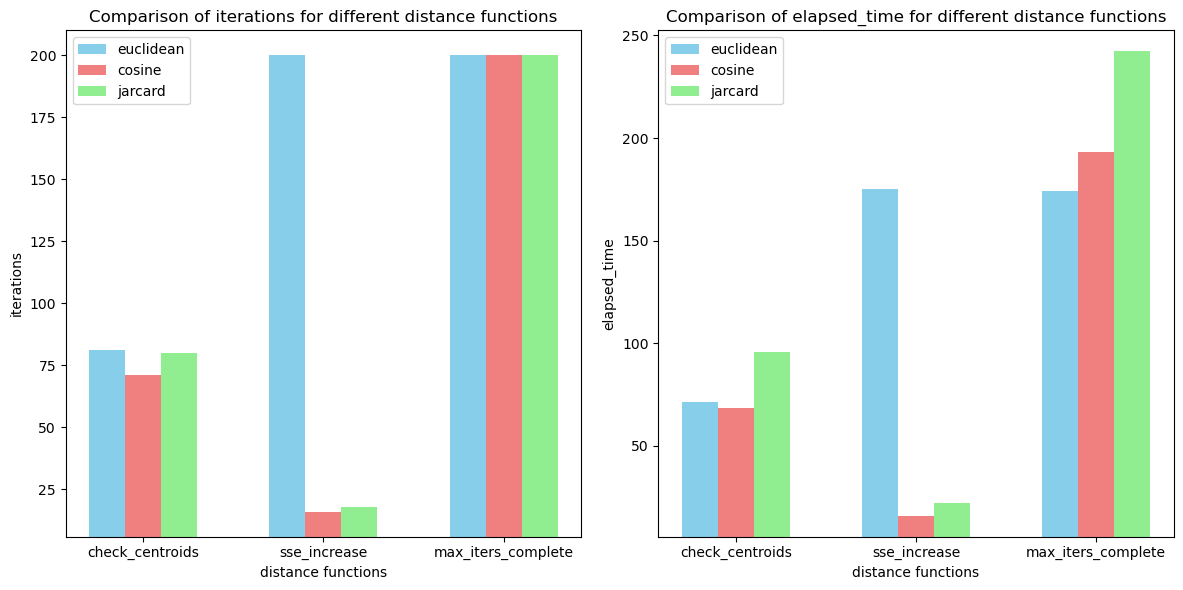

In [99]:
# Q3 Plot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Iterations
axes[0].bar(np.arange(len(stop_criteria_list)) - 0.2, [results["euclidean_distance"][metric]['iterations'] for metric in stop_criteria_list], width=0.2, color='skyblue', label='euclidean')
axes[0].bar(np.arange(len(stop_criteria_list)) + 0, [results["cosine_distance"][metric]['iterations'] for metric in stop_criteria_list], width=0.2, color='lightcoral', label='cosine')
axes[0].bar(np.arange(len(stop_criteria_list)) + 0.2, [results["jarcard_distance"][metric]['iterations'] for metric in stop_criteria_list], width=0.2, color='lightgreen', label='jarcard')
axes[0].set_title('Comparison of iterations for different distance functions')
axes[0].set_xlabel('distance functions')
axes[0].set_ylabel('iterations')
axes[0].set_xticks(np.arange(len(stop_criteria_list)))
axes[0].set_xticklabels(stop_criteria_list)
axes[0].legend()
axes[0].set_ylim(min(min([results["euclidean_distance"][metric]['iterations'] for metric in stop_criteria_list]), min([results["cosine_distance"][metric]['iterations'] for metric in stop_criteria_list]), min([results["jarcard_distance"][metric]['iterations'] for metric in stop_criteria_list])) - 10, \
                 max(max([results["euclidean_distance"][metric]['iterations'] for metric in stop_criteria_list]), max([results["cosine_distance"][metric]['iterations'] for metric in stop_criteria_list]), max([results["jarcard_distance"][metric]['iterations'] for metric in stop_criteria_list])) + 10)

# Elapsed Time
axes[1].bar(np.arange(len(stop_criteria_list)) - 0.2, [results["euclidean_distance"][metric]['elapsed_time'] for metric in stop_criteria_list], width=0.2, color='skyblue', label='euclidean')
axes[1].bar(np.arange(len(stop_criteria_list)) + 0, [results["cosine_distance"][metric]['elapsed_time'] for metric in stop_criteria_list], width=0.2, color='lightcoral', label='cosine')
axes[1].bar(np.arange(len(stop_criteria_list)) + 0.2, [results["jarcard_distance"][metric]['elapsed_time'] for metric in stop_criteria_list], width=0.2, color='lightgreen', label='jarcard')
axes[1].set_title('Comparison of elapsed_time for different distance functions')
axes[1].set_xlabel('distance functions')
axes[1].set_ylabel('elapsed_time')
axes[1].set_xticks(np.arange(len(stop_criteria_list)))
axes[1].set_xticklabels(stop_criteria_list)
axes[1].legend()
axes[1].set_ylim(min(min([results["euclidean_distance"][metric]['elapsed_time'] for metric in stop_criteria_list]), min([results["cosine_distance"][metric]['elapsed_time'] for metric in stop_criteria_list]), min([results["jarcard_distance"][metric]['elapsed_time'] for metric in stop_criteria_list])) - 10, \
                 max(max([results["euclidean_distance"][metric]['elapsed_time'] for metric in stop_criteria_list]), max([results["cosine_distance"][metric]['elapsed_time'] for metric in stop_criteria_list]), max([results["jarcard_distance"][metric]['elapsed_time'] for metric in stop_criteria_list])) + 10)

plt.tight_layout()
plt.show()

In [105]:
# Q4 Output

for distance_function in results.keys():
    print(distance_function)
    for stop_criteria in results[distance_function].keys():
        sse = results[distance_function][stop_criteria]["sse"]
        print(f"{stop_criteria} -> SSE: {sse:.2f}")

euclidean_distance
check_centroids -> SSE: 25433212639.24
sse_increase -> SSE: 25433212639.24
max_iters_complete -> SSE: 25433212639.24
cosine_distance
check_centroids -> SSE: 25419566794.00
sse_increase -> SSE: 25440247462.49
max_iters_complete -> SSE: 25419566794.00
jarcard_distance
check_centroids -> SSE: 25417331725.24
sse_increase -> SSE: 25487498983.53
max_iters_complete -> SSE: 25417331725.24


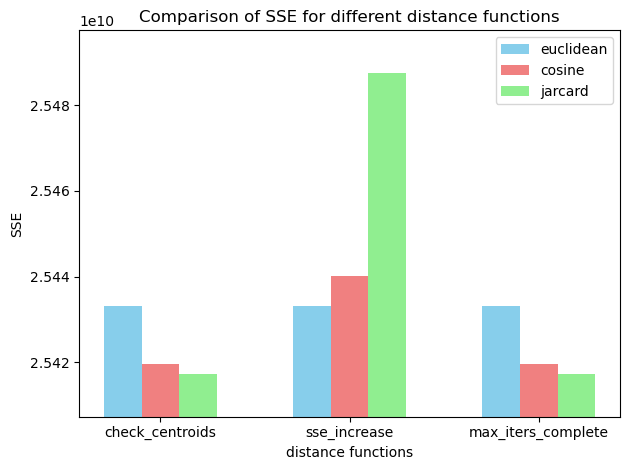

In [108]:
# Q4 Plot

plt.bar(np.arange(len(stop_criteria_list)) - 0.2, [results["euclidean_distance"][metric]['sse'] for metric in stop_criteria_list], width=0.2, color='skyblue', label='euclidean')
plt.bar(np.arange(len(stop_criteria_list)) + 0, [results["cosine_distance"][metric]['sse'] for metric in stop_criteria_list], width=0.2, color='lightcoral', label='cosine')
plt.bar(np.arange(len(stop_criteria_list)) + 0.2, [results["jarcard_distance"][metric]['sse'] for metric in stop_criteria_list], width=0.2, color='lightgreen', label='jarcard')
plt.title('Comparison of SSE for different distance functions')
plt.xlabel('distance functions')
plt.ylabel('SSE')
plt.xticks(np.arange(len(stop_criteria_list)), stop_criteria_list)
plt.legend()
plt.ylim(min(min([results["euclidean_distance"][metric]['sse'] for metric in stop_criteria_list]), min([results["cosine_distance"][metric]['sse'] for metric in stop_criteria_list]), min([results["jarcard_distance"][metric]['sse'] for metric in stop_criteria_list])) - 10000000, \
                 max(max([results["euclidean_distance"][metric]['sse'] for metric in stop_criteria_list]), max([results["cosine_distance"][metric]['sse'] for metric in stop_criteria_list]), max([results["jarcard_distance"][metric]['sse'] for metric in stop_criteria_list])) + 10000000)

plt.tight_layout()
plt.show()

In [109]:
# Testing with sklearn library
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
sse = calculate_sse(X, labels, centroids)
accuracy = calculate_accuracy(labels, y)
print("SSE: {:.2f}, Accuracy: {:.2f}".format(sse, accuracy * 100))

SSE: 25320432712.92, Accuracy: 59.48
